In [229]:
import re
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
# import chartify
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

stopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/6ones/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/6ones/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/6ones/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [204]:
sns.set_theme(style='darkgrid', context="notebook");
# sns.despine();

In [206]:
def load_data(file_location):
    df = pd.read_csv(file_location, index_col=False)
    return df


def clean_data(df):
    df = df.drop(['id_str'], axis=1)
    df = df.drop_duplicates()
    df = df.set_index('id')
    return df


def drop_cols(df, cols):
    """Drop columns"""
    df = df.drop(cols, axis='columns')
    return df


def to_datetime(df, cols):
    """Convert date columns to pandas datetime"""
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    return df

In [207]:
df = load_data('./data/livongo.csv')

columns_to_drop = ['user_id_str','in_reply_to_status_id_str','in_reply_to_user_id_str','in_reply_to_screen_name','user_description']
date_columns = ['user_created_at','created_at']

df = (df
      .pipe(clean_data)
      .pipe(drop_cols, columns_to_drop)
      .pipe(to_datetime, date_columns))

## Analysis on Tweets

### 1. Sentiment Analysis

In [208]:
def determine_sentiment(row):
    score, magnitude = row['score'], row['magnitude']
    if (score < -0.3 and magnitude >= 0.5):
        return 'negative'
    if (score < -0.5):
        return 'negative'
    if (score >= 0.3):
        return 'positive'
    return 'neutral'


def categorize_sentiment_score(df):
    """Categorize the sentiment score"""
    # df['sentiment'] = pd.cut(df.score, 3,labels=['negative','neutral','positive'])
    df['sentiment'] = df.apply(lambda row: determine_sentiment(row), axis=1)
    return df
 
df = df.pipe(categorize_sentiment_score)

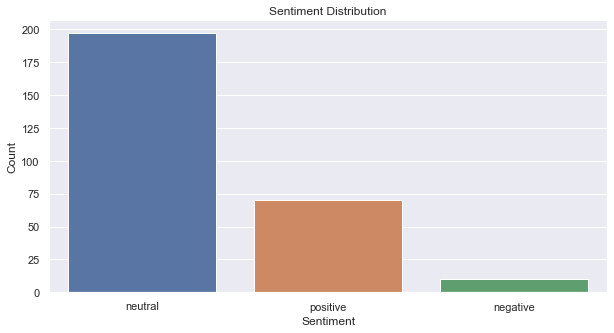

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

sns.countplot(x='sentiment', 
              data=df,
              ax=ax,
              order = df['sentiment'].value_counts().index)

plt.title('Sentiment Distribution');
plt.xlabel('Sentiment')
plt.ylabel('Count');

In [210]:
def chart_sentiment(sentiment, ax = None):
    """Chart the sentiment"""
    try:
        chart = df.loc[df.sentiment == sentiment]
        hourly_sample = chart.set_index('created_at').resample('H').sum()
        hourly_sample.favorite_count.plot(ax=ax, label="Likes")
        hourly_sample.retweet_count.plot(ax=ax, label="Retweets")
        ax.legend()
        ax.set_title(f'{sentiment.upper()} sentiment')
        ax.set_xlabel('Date')
        ax.set_ylabel('Count')
    except KeyError as e:
        print(f'{sentiment} is not a sentiment. Use either "positive", "neutral", "negative"')
    except:
        e = sys.exc_info()[0]
        print('Unknown error: ', e)

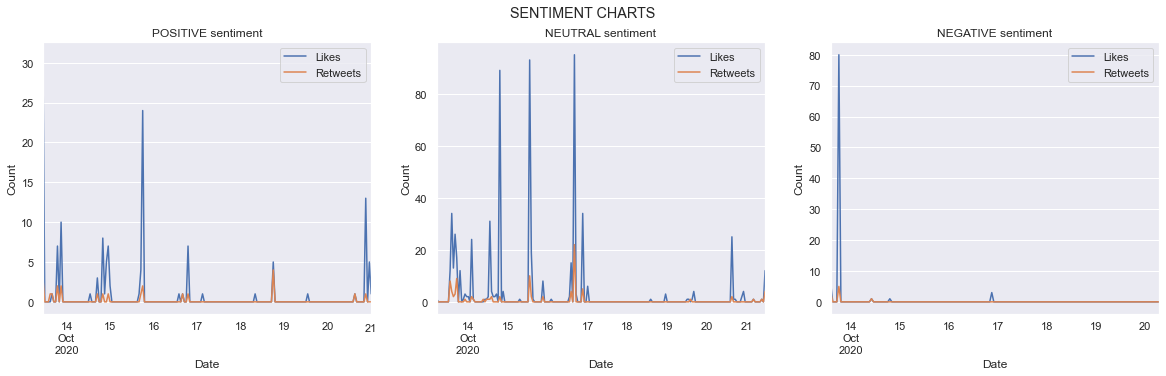

In [211]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

chart_sentiment('positive',axes[0])
chart_sentiment('neutral',axes[1])
chart_sentiment('negative',axes[2])
plt.suptitle('Sentiment charts'.upper());

### 2. Text Analysis

In [212]:
tf_idf_vec = TfidfVectorizer(stop_words='english', max_features=20000)
tf_idf = tf_idf_vec.fit_transform(df.text)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [213]:
def determine_clusters(tf_idf_array):
    pca = PCA(n_components=2)
    y = pca.fit_transform(tf_idf_array)
    n_clusters = range(1,7)
    kmeans = [KMeans(n_clusters=i, max_iter=600) for i in n_clusters]
    
    score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]
    plt.plot(n_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Method')

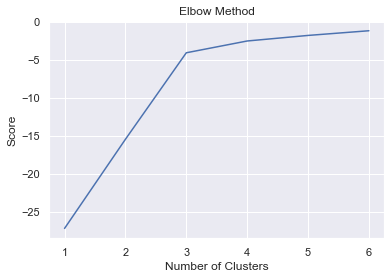

In [214]:
determine_clusters(tf_idf_array)

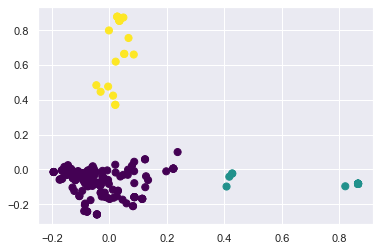

In [215]:
pca = PCA(n_components=2)
x = pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm='auto')

labels = kmeans.fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c=labels, s=50, cmap='viridis');

In [216]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vec.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

dfs = get_top_features_cluster(tf_idf_array, labels, 15)

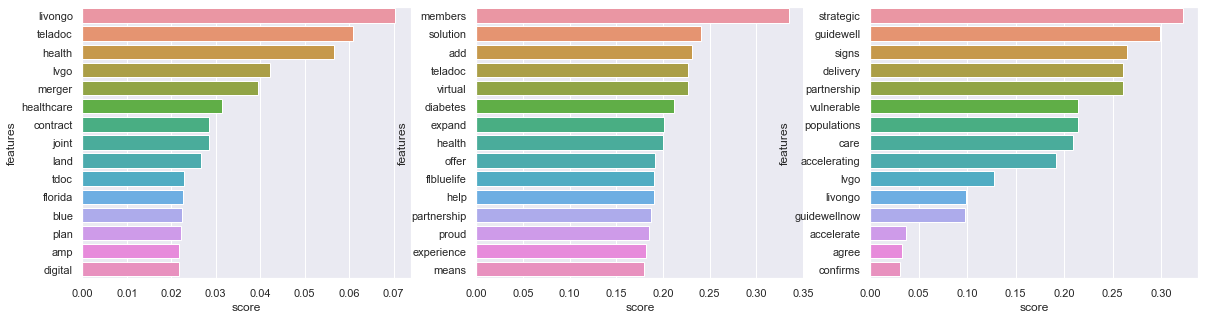

In [218]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

sns.barplot(x='score',y='features',data=dfs[0], orient='h', ax=axes[0])
sns.barplot(x='score',y='features',data=dfs[1], orient='h', ax=axes[1])
sns.barplot(x='score',y='features',data=dfs[2], orient='h', ax=axes[2]);

In [248]:
all_text = df['text'].str.split()
all_text = all_text.values.tolist()

corpus = [word.lower() for i in all_text for word in i]

In [267]:
words_in_tweets = []

for word in corpus:
    if word not in stopwords:
        words_in_tweets.append(word)

for symbol in ['-', '&']:
    for word in words_in_tweets:
        if symbol in word:
            words_in_tweets.remove(word)

In [268]:
counter = Counter(words_in_tweets)
most = counter.most_common()

In [269]:
x, y = [], []
for word, count in most[:40]:
    x.append(word)
    y.append(count)

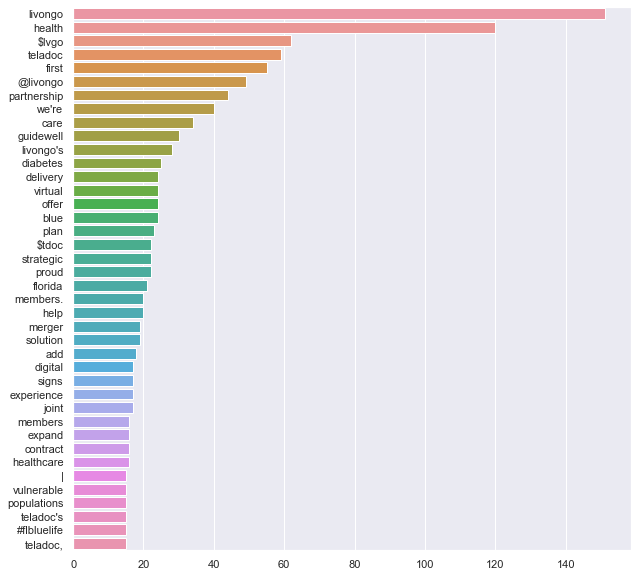

In [274]:
fig, axes = plt.subplots(1, 1, figsize=(10,10))


sns.barplot(x=y,y=x, ax=axes);